In [1]:
%matplotlib inline
# %matplotlib ipympl
import matplotlib as mpl
# matplotlib.use('Qt5Agg')
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cooler
import matplotlib.font_manager as font_manager
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator, MinuteLocator
from natsort import natsorted
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, ScalarFormatter, FormatStrFormatter, MultipleLocator
from scipy.linalg import toeplitz
from scipy import special
from mirnylib import numutils, plotting
from statsmodels.nonparametric import smoothers_lowess
import json
font_path = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=8)
mpl.rcParams['svg.fonttype'] = u'none'
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
sns.set_context('paper')

# Helper functions

In [2]:
def make_nice(ax, font_prop=font_prop, nicelog=False):
    if nicelog:
        ax.set_xticklabels(['$\mathregular{10^{'+'%i' % np.log10(i)+'}}$'  for i in ax.get_xticks()])
        ax.set_yticklabels(['$\mathregular{10^{'+'%i' % np.log10(i)+'}}$'  for i in ax.get_yticks()])
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontproperties(font_prop)
    ax.set_xlabel(ax.get_xlabel(), fontproperties=font_prop)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=font_prop)
    try:
        l = ax.legend_
        defaults = dict(
            loc = l._loc,
            numpoints = l.numpoints,
            markerscale = l.markerscale,
            scatterpoints = l.scatterpoints,
            scatteryoffsets = l._scatteryoffsets,
            prop = l.prop,
            borderpad = l.borderpad,
            labelspacing = l.labelspacing,
            handlelength = l.handlelength,
            handleheight = l.handleheight,
            handletextpad = l.handletextpad,
            borderaxespad = l.borderaxespad,
            columnspacing = l.columnspacing,
            ncol = l._ncol,
            mode = l._mode,
            fancybox = type(l.legendPatch.get_boxstyle())==mpl.patches.BoxStyle.Round,
            shadow = l.shadow,
            title = l.get_title().get_text() if l._legend_title_box.get_visible() else None,
            framealpha = l.get_frame().get_alpha(),
            bbox_to_anchor = l.get_bbox_to_anchor()._bbox,
            bbox_transform = l.get_bbox_to_anchor()._transform,
            frameon = l._drawFrame,
            handler_map = l._custom_handler_map,
        )
        defaults["prop"]=font_prop
        ax.legend(*ax.get_legend_handles_labels(), **dict(defaults.items()))
    except AttributeError:
        pass

In [3]:
def fill_diagonals(matrix, i=1):
    for i in np.arange(-i, i+1):
        numutils.fillDiagonal(matrix, 0, i)
        
def normCis(amap, i=1):
    return amap/np.nanmean((amap[0:i, 0:i]+amap[-i:, -i:]))*2

def get_enrichment(amap, n, dec=2):
    c = int(np.floor(amap.shape[0]/2))
    return np.round(np.nanmean(amap[c-n//2:c+n//2+1, c-n//2:c+n//2+1]), decimals=dec)

def cornerCV(amap, i=4):
    corners = np.concatenate((amap[0:i, 0:i], amap[-i:, -i:]))
    corners[~np.isfinite(corners)]=0
    return np.std(corners)/np.mean(corners)

# Generating regions of high insulation and TADs

In [4]:
res = 25000
win = 1000000
min_bs = 0.1
insul = pd.read_csv('local/Bonev_ES.mm9.mapq_30.1000.mcool_%s.insulation_%s.bed' % (res, win), sep='\t')
boundaries = insul[['chrom', 'start', 'end', 'boundary_strength_%s' % win]].dropna()
boundaries = boundaries[['chrom', 'start', 'end']][boundaries['boundary_strength_%s' % win] > min_bs]
boundaries.to_csv('local/boundaries_Bonev_ES.mm9.mapq_30.1000.mcool_%s_IS%s_minBS_%s.bed' % (res, win, min_bs), sep='\t', index=False, header=False)

TADs = pd.merge(boundaries[:-1].reset_index(drop=True), boundaries[1:].reset_index(drop=True), left_index=True, right_index=True, suffixes=['1', '2'])
TADs = TADs[TADs['chrom1']==TADs['chrom2']]

l = TADs['start2']-TADs['start1']
TADs[l<1.5*10**6][['chrom1', 'end1', 'start2']].to_csv('local_rescaled/TADs_Bonev_ES.mm9.mapq_30.1000.mcool_%s_IS%s_minBS_%s.bed' % (res, win, min_bs), sep='\t', index=False, header=False)

# Figure 1
## Coverage normalization

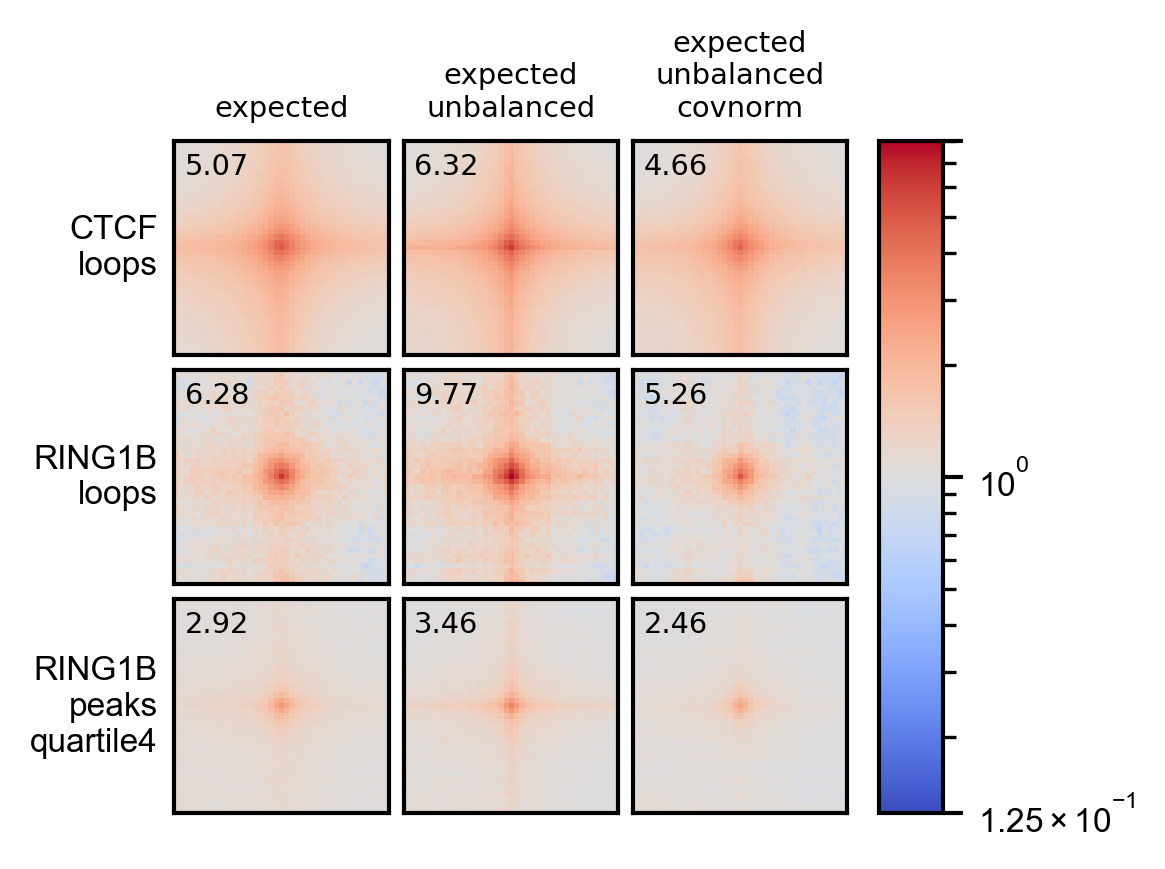

In [5]:
files = natsorted(glob.glob('balancing/pileups/*.np.txt'))
names = [f.split('/')[-1] for f in files]
conds = [f.split('_over_')[1].split('5kb_')[-1].split('Q4_')[-1].split('.')[0] for f in names]
beds = [f.split('_over_')[1].split('_5kb_')[0].split('Q4_')[0] for f in names]

loops = {}
for c in set(conds):
    loops[c] = {}
for f, cond, bed in zip(files, conds, beds):
    loops[cond][bed] = np.loadtxt(f)

cols = [i for i in list(sorted(set(conds))) if 'expected' in i and 'noNorm' not in i]
rownames = ['CTCF\nloops', 'RING1B\nloops', 'RING1B\npeaks\nquartile4']
rows = list(sorted(set(beds)))
f = plt.figure(dpi=300, figsize=(8.4/2.54, 23/3/2.54))
grid = ImageGrid(f, 111,  share_all=False,
                 nrows_ncols=(len(rows), len(cols)),
                 direction='column',
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="L",
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad="5%",
                 cbar_set_cax=True
                 )
axarr = np.array(grid).reshape((len(cols), len(rows)))
cbarr = np.array(grid.cbar_axes).reshape((len(cols), len(rows)))
for i, cond in enumerate(cols):
    amax = 8
    amin = 2**-np.log2(amax)
    for j, bed in enumerate(rows):
        n1 = cols.index(cond)
        n2 = rows.index(bed)
        data = loops[cond][bed]
        m = axarr[n1, n2].imshow(normCis(data, 1), cmap='coolwarm', norm=LogNorm(vmax=amax, vmin=amin))
        axarr[n1, n2].set_yticks([], [])
        axarr[n1, n2].set_xticks([], [])
        axarr[n1, n2].set_ylabel(rownames[j], size='x-small', rotation=0, ha='right', va='center')
        axarr[n1, n2].text(s=get_enrichment(normCis(data), 1), y=0.95, x=0.05, ha='left', va='top',
                           size='x-small',
                           transform = axarr[n1, n2].transAxes)
        make_nice(axarr[n1, n2])
        axarr[n1, 0].set_title(cond.replace('_', '\n'), rotation=0, size='x-small')
cb = plt.colorbar(m, grid.cbar_axes[0])
cb.set_ticks([amin, 1, amax])
make_nice(cb.ax)
# plt.savefig('Figure_panels/Fig1A.svg', bbox_inches='tight')
plt.show()

## Distance normalization
Note that here we generated pileups with shorter mindist to make artefacts from short distances in Hi-C more pronounced - noNorm look nice with default --mindist

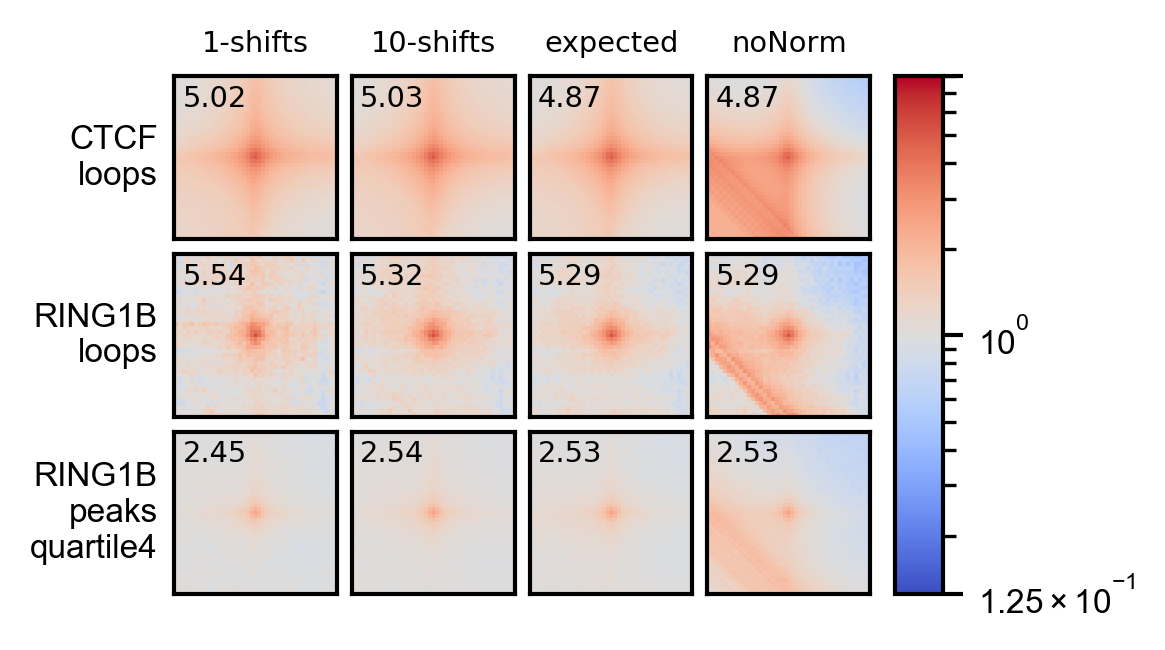

In [6]:
files = natsorted(glob.glob('expected/pileups/*.np.txt'))
names = [f.split('/')[-1] for f in files]
conds = [f.split('_dist_')[0].split('_')[-1] for f in names]
beds = [f.split('_over_')[1].split(cond)[0] for f, cond in zip(names, conds)]

loops = {}
for c in set(conds):
    loops[c] = {}
for f, cond, bed in zip(files, conds, beds):
    loops[cond][bed] = np.loadtxt(f)

cols = ['1-shifts', '10-shifts', 'expected', 'noNorm']
rows = list(sorted(set(beds)))
rownames = ['CTCF\nloops', 'RING1B\nloops', 'RING1B\npeaks\nquartile4']
f = plt.figure(dpi=300, figsize=(8.4/2.54, 23/3/2.54))
grid = ImageGrid(f, 111,  share_all=False,
                 nrows_ncols=(len(rows), len(cols)),
                 direction='column',
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="L",
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad="5%",
                 cbar_set_cax=True
                 )
axarr = np.array(grid).reshape((len(cols), len(rows)))
cbarr = np.array(grid.cbar_axes).reshape((len(cols), len(rows)))
for i, cond in enumerate(cols):
    amax = 8
    amin = 2**-np.log2(amax)
    for j, bed in enumerate(rows):
        n1 = cols.index(cond)
        n2 = rows.index(bed)
        data = loops[cond][bed]
        m = axarr[n1, n2].imshow(normCis(data, 1), cmap='coolwarm', norm=LogNorm(vmax=amax, vmin=amin))
        axarr[n1, n2].set_yticks([], [])
        axarr[n1, n2].set_xticks([], [])
        axarr[n1, n2].set_ylabel(rownames[j], size='x-small', rotation=0, ha='right', va='center')#bed.replace('_', '\n')
        axarr[n1, n2].text(s=get_enrichment(normCis(data), 1), y=0.95, x=0.05, ha='left', va='top',
                           size='x-small',
                           transform = axarr[n1, n2].transAxes)
        make_nice(axarr[n1, n2])
        axarr[n1, 0].set_title(cond, rotation=0, size='x-small')
cb = plt.colorbar(m, grid.cbar_axes[0])
cb.set_ticks([amin, 1, amax])
make_nice(cb.ax)
# plt.savefig('Figure_panels/Fig1B.svg', bbox_inches='tight')
plt.show()

# Figure 2
## Local pileups

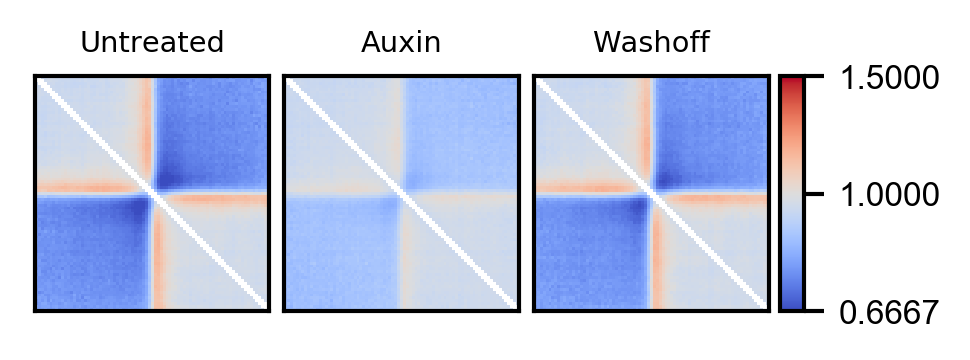

In [7]:
files = natsorted(glob.glob('local/pileups/*25.0K*boundaries*25000*expected_local.np.txt'))
names = [f.split('/')[-1] for f in files]
conds = [f.split('_over_')[0].split('.mm9')[0] for f in names]

loops = {}
for c in set(conds):
    loops[c] = {}
for f, cond in zip(files, conds):
    loops[cond] = np.loadtxt(f)

cols = ['Untreated', 'Auxin', 'Washoff']
rows = list(sorted(set(beds)))
f = plt.figure(dpi=300, figsize=(8.4/2.54, 23/3/2.54))
grid = ImageGrid(f, 111,  share_all=False,
                 nrows_ncols=(1, len(cols)),
                 direction='column',
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="L",
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="10%",
                 cbar_pad="5%",
                 cbar_set_cax=True
                 )
axarr = np.array(grid)
amax = 1.5
amin = 2**-np.log2(amax)
cmap = 'coolwarm'     
for i, cond in enumerate(cols):
    data = loops[cond]
    m = axarr[i].imshow(data, cmap=cmap, norm=LogNorm(vmax=amax, vmin=amin))
    axarr[i].set_yticks([], [])
    axarr[i].set_xticks([], [])
    axarr[i].set_title(cond.replace('_', '\n'), rotation=0, size='x-small')
    make_nice(axarr[i])
cb = plt.colorbar(m, grid.cbar_axes[0])
cb.set_ticks([amin, 1, amax])
cb.ax.minorticks_off()
cb.ax.yaxis.set_major_formatter(ScalarFormatter())
make_nice(cb.ax)
plt.savefig('Figure_panels/Fig2A.pdf', bbox_inches='tight')

## Local rescaled pileups

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply


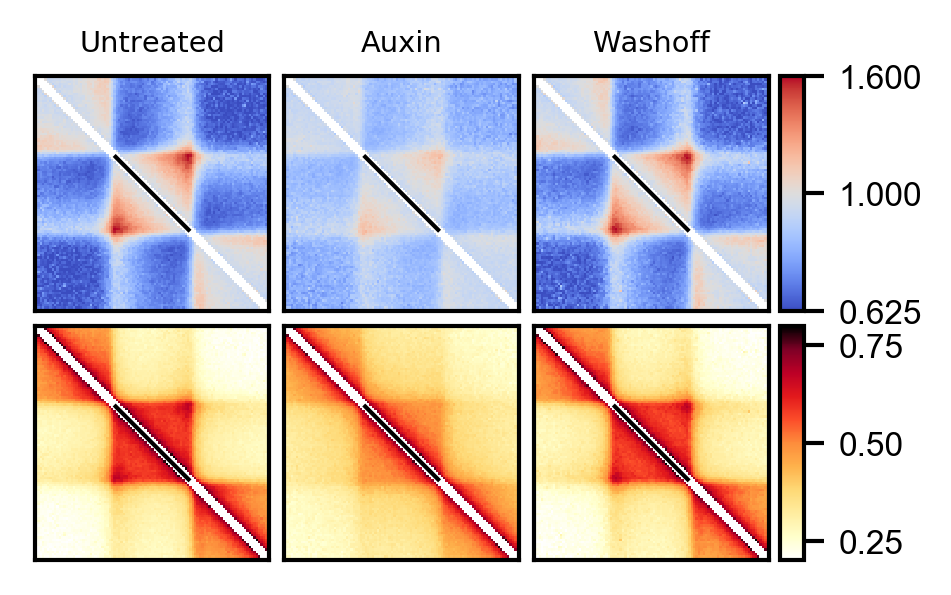

In [8]:
files = natsorted(glob.glob('local_rescaled/pileups/*.np.txt'))
names = [f.split('/')[-1] for f in files]
conds = [f.split('_over_')[0].split('.mm9')[0] for f in names]

loops = {}
for c in set(conds):
    loops[c] = {}
for f, cond in zip(files, conds):
    loops[cond] = np.loadtxt(f)

    
side = np.arange(len(loops['Untreated']))**-0.25
tad_scaling = toeplitz(side, side)
    
cols = ['Untreated', 'Auxin', 'Washoff']
rows = list(sorted(set(beds)))
f = plt.figure(dpi=300, figsize=(8.4/2.54, 23/3/2.54))
grid = ImageGrid(f, 111,  share_all=False,
                 nrows_ncols=(2, len(cols)),
                 direction='column',
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="L",
                 cbar_location="right",
                 cbar_mode="edge",
                 cbar_size="10%",
                 cbar_pad="5%",
                 cbar_set_cax=True
                 )
axarr = np.array(grid).reshape((len(cols), 2))
amax = 1.6
amin = 2**-np.log2(amax)

for i, cond in enumerate(cols):
    data = loops[cond]
    fill_diagonals(data, 2)
    m = axarr[i, 0].imshow(data, cmap='coolwarm', norm=LogNorm(vmax=amax, vmin=amin))
    axarr[i, 0].set_yticks([], [])
    axarr[i, 0].set_xticks([], [])
    axarr[i, 0].set_title(cond.replace('_', '\n'), rotation=0, size='x-small')
    axarr[i, 0].plot([33, 65], [33, 65], color='k', linewidth=1, solid_capstyle='butt')
    make_nice(axarr[i, 0])
cb = plt.colorbar(m, grid.cbar_axes[0])
cb.set_ticks([amin, 1, amax])
cb.ax.minorticks_off()
cb.ax.yaxis.set_major_formatter(ScalarFormatter())
make_nice(cb.ax)

for i, cond in enumerate(cols):
    data = loops[cond]*tad_scaling
    fill_diagonals(data, 2)
    m = axarr[i, 1].imshow(data, cmap='fall', vmin=0.2, vmax=0.8)
    axarr[i, 1].set_yticks([], [])
    axarr[i, 1].set_xticks([], [])
    axarr[i, 1].plot([33, 65], [33, 65], color='k', linewidth=1, solid_capstyle='butt')
    make_nice(axarr[i, 1])
cb = plt.colorbar(m, grid.cbar_axes[1])
cb.ax.minorticks_off()
make_nice(cb.ax)
# plt.savefig('Figure_panels/Fig2B.pdf', bbox_inches='tight')

## snHi-C

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in power


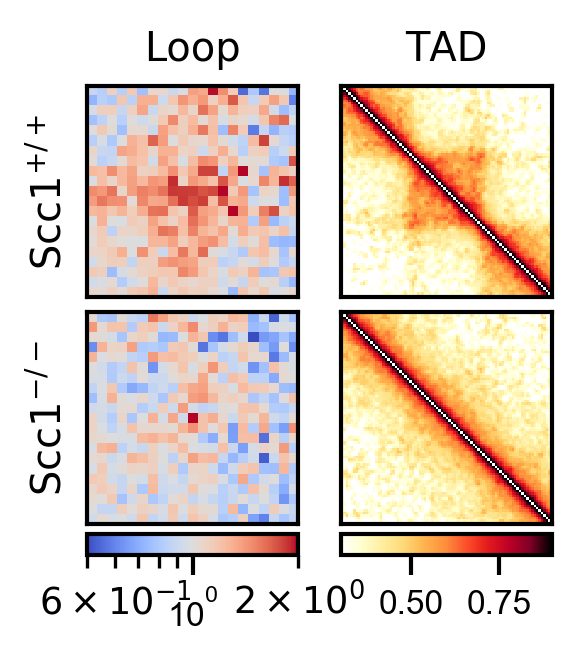

In [9]:
tadWT = np.loadtxt('snHi-C/pileups/Scc1-control.10000-10.0K_over_CH12_TADs_Rao_10-shifts_local_rescaled_unbalanced_covnorm.np.txt')
tadKO = np.loadtxt('snHi-C/pileups/Scc1-KO.10000-10.0K_over_CH12_TADs_Rao_10-shifts_local_rescaled_unbalanced_covnorm.np.txt')
loopWT = np.loadtxt('snHi-C/pileups/Scc1-control.10000-10.0K_over_CH12_loops_Rao_10-shifts_unbalanced_covnorm.np.txt')
loopKO = np.loadtxt('snHi-C/pileups/Scc1-KO.10000-10.0K_over_CH12_loops_Rao_10-shifts_unbalanced_covnorm.np.txt')
amax = 2
amin = 0.5
f = plt.figure(dpi=300, figsize=(2, 6))

grid = ImageGrid(f, 121,  share_all=False,# similar to subplot(111)
                 nrows_ncols=(2, 1),
                 direction='column',
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="L",
                 cbar_location="bottom",
                 cbar_mode="edge",
                 cbar_size="10%",
                 cbar_pad="5%",
                 cbar_set_cax=True
                 )
axarr = np.array(grid)
m = grid[0].imshow(loopWT, cmap='coolwarm', norm=LogNorm(vmax=amax, vmin=amin))
m = grid[1].imshow(loopKO, cmap='coolwarm', norm=LogNorm(vmax=amax, vmin=amin))

grid[0].set_ylabel('Scc1$^{+/+}$')
grid[1].set_ylabel('Scc1$^{-/-}$')

grid[0].set_title('Loop')
cb = plt.colorbar(m, grid[-1].cax, orientation='horizontal')

plt.setp(grid, xticks=[], yticks=[])
map(make_nice, grid[:])
make_nice(cb.ax)


side = np.arange(87)**-0.25
tad_scaling = toeplitz(side, side)

grid = ImageGrid(f, 122,  share_all=False,
                 nrows_ncols=(2, 1),
                 direction='column',
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="L",
                 cbar_location="bottom",
                 cbar_mode="edge",
                 cbar_size="10%",
                 cbar_pad="5%",
                 cbar_set_cax=True
                 )
axarr = np.array(grid)
m = grid[0].imshow(tadWT*tad_scaling, cmap='fall', vmin=0.3, vmax=0.9)
m = grid[1].imshow(tadKO*tad_scaling, cmap='fall', vmin=0.3, vmax=0.9)
grid[0].set_title('TAD')
cb = plt.colorbar(m, grid[-1].cax, orientation='horizontal')
# cb.ax.set_xticks([0.3, 0.6, 0.9])
# cb.ax.set_yticks([])

plt.setp(grid, xticks=[], yticks=[])

map(make_nice, grid[:])
make_nice(cb.ax)
plt.savefig('Figure_panels/Fig2C.pdf', bbox_inches='tight')

## Loopability examples

In [10]:
files = glob.glob('loopability/enrichment/*.txt')
beds = list(map(lambda x: x.split('_over_')[1].split('_expected')[0], files))
data = [pd.read_table(file) for file in files]
alldata = []
for bed, d in zip(beds, data):
    d['regions'] = bed
    alldata.append(d)
data = pd.concat(alldata).reset_index(drop=True)

In [11]:
with open('loopability/enrichment/Enrichment_Bonev_ES.mm9.mapq_30.1000-5.0K_over_CGI_R1BpK27p_expected.json', 'r') as f:
    maps = json.load(f)

In [12]:
data['ucsc'] = data['chr'].str.cat(data['start'].astype(str), sep=':').str.cat(data['end'].astype(str), sep='-')

In [13]:
chr1doublepos = data[(data['chr']=='chr1') & (data['regions']=='CGI_R1BpK27p')]
regions = [chr1doublepos[(chr1doublepos['Enrichment1']<1.1) & (chr1doublepos['Enrichment1']>0.95)].iloc[-1],
           chr1doublepos[chr1doublepos['Enrichment1']>5].iloc[-2]]
low = np.asarray(maps[regions[0]['ucsc']][1])
hi  = np.asarray(maps[regions[1]['ucsc']][1])

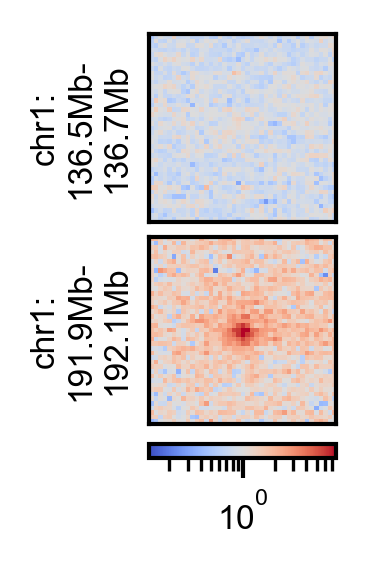

In [14]:
amax = 7.69#7.7round(get_enrichment(hi, 1), 1)
amin = 2**-np.log2(amax)
f = plt.figure(dpi=300, figsize=(1.5, 1.872))
grid = ImageGrid(f, 111,  share_all=False,
                 nrows_ncols=(2, 1),
                 direction='column',
                 axes_pad=0.05,
                 add_all=True,
                 label_mode="L",
                 cbar_location="bottom",
                 cbar_mode="single",
                 cbar_size="7.5%",
                 cbar_pad="3%",
                 cbar_set_cax=True
                 )
axarr = np.array(grid)
m = grid[0].imshow(low, cmap='coolwarm', norm=LogNorm(vmax=amax, vmin=amin))
center = int(np.round(np.mean(regions[0][['start', 'end']])))
coords = center-100000, center, center+100000
s="%s:\n%sMb-\n%sMb" % (regions[0]['chr'],
                      round((regions[0]['start']//5000*5000-100000)/10**6, 1),
                      round((regions[0]['end']//5000*5000+100000)/10**6, 1))
grid[0].set_ylabel(s, size='xx-small')
m = grid[1].imshow(hi, cmap='coolwarm', norm=LogNorm(vmax=amax, vmin=amin))
s="%s:\n%sMb-\n%sMb" % (regions[1]['chr'],
                      round((regions[1]['start']//5000*5000-100000)/10**6, 1),
                      round((regions[1]['end']//5000*5000+100000)/10**6, 1))
grid[1].set_ylabel(s, size='xx-small')

plt.setp(grid, xticks=[], yticks=[])

plt.colorbar(m, cax=grid[1].cax, orientation='horizontal')
make_nice(grid[0])
make_nice(grid[1])
make_nice(grid[1].cax)
plt.savefig('Figure_panels/Fig2D.pdf', bbox_inches='tight')

## Loopability distribution

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


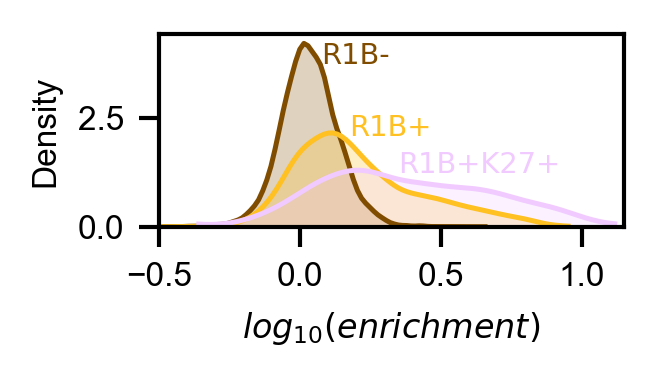

In [15]:
f, ax = plt.subplots(dpi=300, figsize=(2, 0.85))
palette = ['#804d00', '#ffc022', '#f1caff']
locs = [(0.075, 3.75), (0.175, 2.1), (0.35, 1.25)]
for i, bed in enumerate(['CGI_R1Bn', 'CGI_R1Bp', 'CGI_R1BpK27p']):
    enr = data[data['regions']==bed]['Enrichment1']
    sns.kdeplot(data=np.log10(enr), cut=0, ax=ax, label=bed.replace('p', '+').replace('n', '-'), shade=True, color=palette[i])
    plt.text(locs[i][0], locs[i][1], bed.replace('p', '+').replace('n', '-')[4:], color=palette[i], size='x-small')
plt.xlim(-0.5, 1.15)
plt.xlabel('$log_{10}(enrichment)$')
plt.ylabel('Density')
ax.legend_.remove()
make_nice(ax)
plt.savefig('Figure_panels/Fig2E.pdf', bbox_inches='tight')

# Figure 3

## Reading all data
First the annotaiton table from GEO

In [16]:
annot = pd.read_table('Nagano/GSE94489_serum_diploids_features_table.txt')#.dropna()
annot = annot[annot['passed_qc'].astype(bool)]
# annot = annot[annot['cond']=='Serum_G1/S']

Then all pileups. Don't forget to ungzip/untar them first if you want to start with raw pileup files, alternatively skip the next cell and use the one below to load a 

Calculating enrichment in all pileups, and the noise level by coefficient of variation of top-left and bottom-right corners

Saving key information about cells required for further analysis

In [17]:
# Use this to load the data with precalculated enrichments
data = pd.read_csv('Nagano/data.tsv', sep='\t')

Choosing the cutoff of coefficient of variation of corners:

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Density')

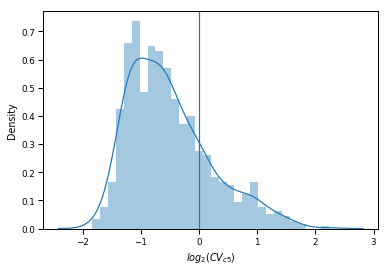

In [18]:
sns.distplot(np.log2(data[data['Loop_set']=='R1BPeak_All']['CV5']), bins=30)
plt.axvline(0) # Corresponds to 1 before log-transform, and looks good - only retains the major peak
plt.xlabel('$log_2(CV_{c5})$')
plt.ylabel('Density')

In [19]:
d = data[data['CV5']<1]

In [20]:
def lowess(data, loops, frac=0.1, col='Enrichment3'):
    xy = smoothers_lowess.lowess(data[data['Loop_set']==loops][col].values, data[data['Loop_set']==loops]['ord'].values, frac=frac)
    x = xy[:, 0]
    y = xy[:, 1]
    return x, y

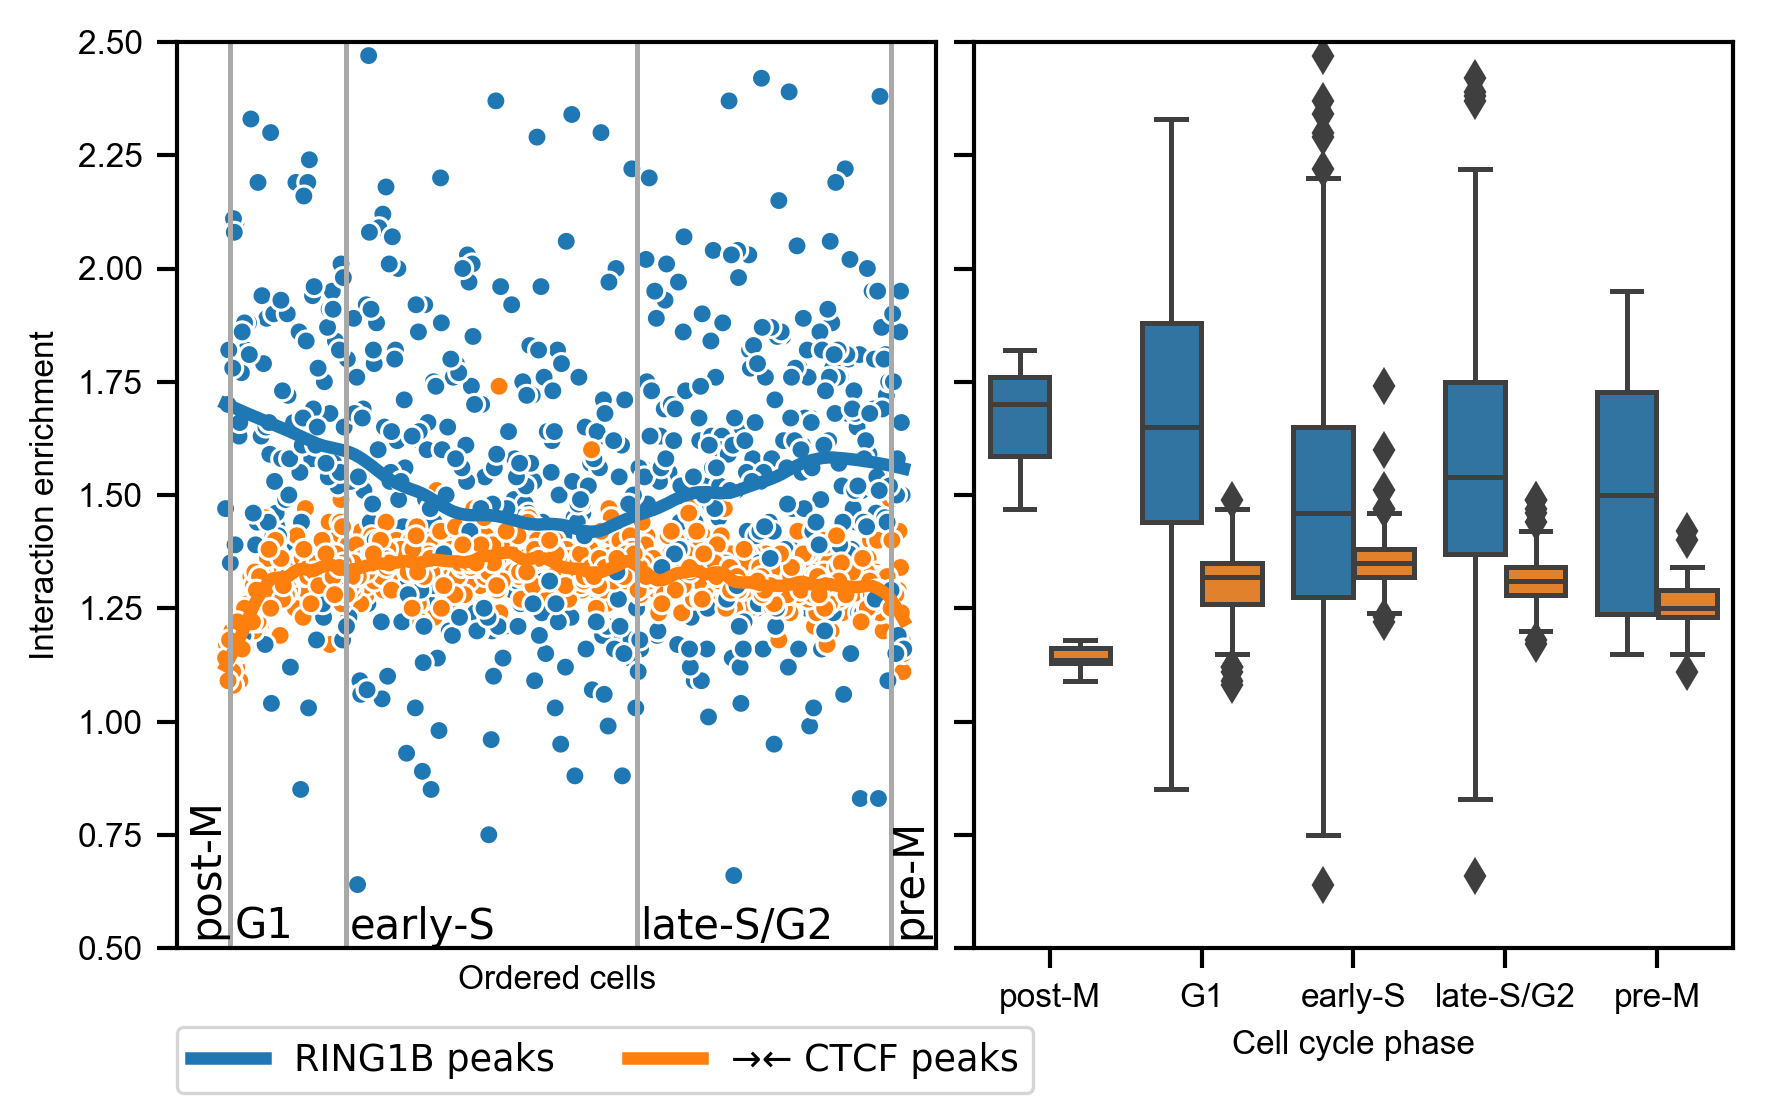

In [21]:
col = 'Enrichment3'
stages = ['post-M', 'G1', 'early-S', 'late-S/G2', 'pre-M']

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(6.69, 4), sharey=True, gridspec_kw=dict(wspace=0.05), dpi=300)
sns.scatterplot(data=d, x='ord', y=col, hue='Loop_set', hue_order=['R1BPeak_All', 'Bonev_ES_CTCF_pairs_+-'], ax=ax0, legend=False)#, order=stages)
x, y = lowess(d, 'R1BPeak_All', 0.25, col=col)
ax0.plot(x, y, lw=3, label='RING1B peaks')
x, y = lowess(d, 'Bonev_ES_CTCF_pairs_+-', 0.05, col=col)
ax0.plot(x, y, lw=3, label='\u2192\u2190 CTCF peaks')

ax0.set_ylim(0.5, 2.5)
for stage in 'G1', 'early-S', 'late-S/G2', 'pre-M':
    x = data[data['group']==stage]['ord'].min()
    ax0.axvline(x, c='darkgrey')
    if stage != 'pre-M':
        t = ax0.text(x+5, 0.52, stage)

ax0.set_xlim(-60, 900)

ax0.text(840, 0.52, 'pre-M', rotation=90, ha='left', va='bottom')
ax0.text(-50, 0.52, 'post-M', rotation=90, ha='left', va='bottom')
ax0.set_xlabel('Ordered cells')
ax0.set_ylabel('Interaction enrichment')
ax0.set_xticks([])

f.legend(loc=(0.1, 0.015), ncol=2)

sns.boxplot(data=d, x='group', y='Enrichment3', hue='Loop_set', order=stages, hue_order=['R1BPeak_All', 'Bonev_ES_CTCF_pairs_+-'], ax=ax1)#, legend=False)#, order=stages)
ax1.set_ylabel('')
ax1.set_xlabel('Cell cycle phase')
ax1.legend_.remove()
make_nice(ax0)
make_nice(ax1)
plt.savefig('Figure_panels/Figure3.svg', bbox_inches='tight')

# Figure 4
## Number of "loops", regions and cores

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


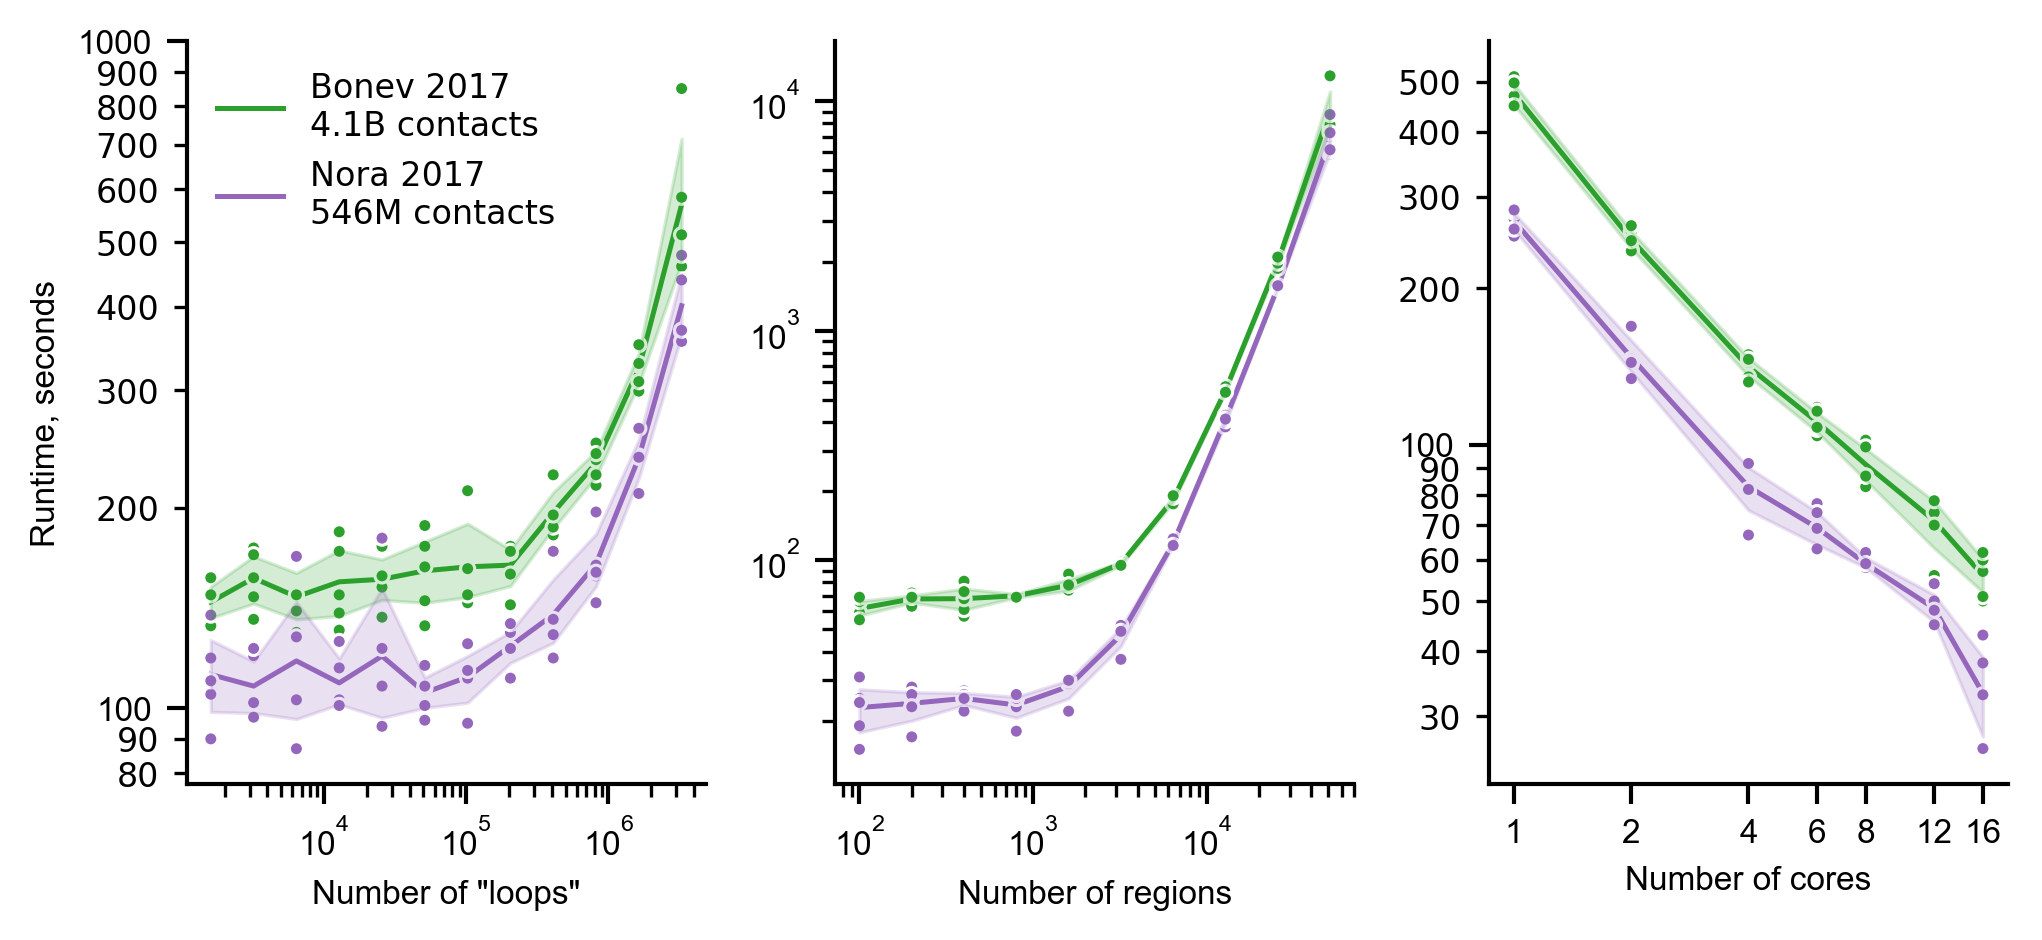

In [22]:
palette = ['C2', 'C4'] #Distinct form other figures, and C2 and C3 are not great for colour-blind people

time_sub_bonev =pd.read_table('timing_subset/time_Bonev_ES.mm9.mapq_30.1000.mcool.txt', names=['N', 'Time'], sep=' ', dtype=int)
time_sub_nora = pd.read_table('timing_subset/time_Untreated.mm9.mapq_30.1000.mcool.txt', names=['N', 'Time'], sep=' ', dtype=int)
time_sub_bonev['Data'] = 'Bonev 2017'
time_sub_nora['Data'] = 'Nora 2017'

time_sub = pd.concat([time_sub_bonev, time_sub_nora])
time_sub = time_sub[time_sub['N']>=1600]

f, (ax0, ax1, ax2) = plt.subplots(1, 3, dpi=300, figsize=(17/2.54, 23/3/2.54), constrained_layout=True)

plt.setp([ax0, ax1, ax2], xscale='log', yscale='log')

sns.scatterplot('N', 'Time', data=time_sub, ax=ax0, palette=palette, hue='Data', size=1)
sns.lineplot('N', 'Time', data=time_sub, ax=ax0, zorder=0, palette=palette, hue='Data')
ax0.set_ylabel('Runtime, seconds')
ax0.set_xlabel('Number of "loops"')
ax0.set_ylim(top=1000)
handles, labels = ax0.get_legend_handles_labels()
ax0.get_legend().remove()

ax0.yaxis.set_major_formatter(ScalarFormatter())
ax0.yaxis.set_minor_formatter(ScalarFormatter())
ax0.tick_params(axis='y', which='minor', labelsize=8)
ax0.tick_params(axis='y', which='major', labelsize=8)

time_comb_bonev =pd.read_table('timing_subset/time_comb_Bonev_ES.mm9.mapq_30.1000.mcool.txt', names=['N', 'Time'], sep=' ', dtype=int)
time_comb_nora = pd.read_table('timing_subset/time_comb_Untreated.mm9.mapq_30.1000.mcool.txt', names=['N', 'Time'], sep=' ', dtype=int)
time_comb_bonev['Data'] = 'Bonev 2017'
time_comb_nora['Data'] = 'Nora 2017'

time_comb = pd.concat([time_comb_bonev, time_comb_nora])

sns.scatterplot('N', 'Time', data=time_comb, ax=ax1, palette=palette, hue='Data', size=1)
sns.lineplot('N', 'Time', data=time_comb, ax=ax1, zorder=0, palette=palette, hue='Data')
ax1.set_ylabel('')
ax1.set_xlabel('Number of regions')
ax1.legend_.remove()

time_cores_bonev =pd.read_table('timing_cores/time_Bonev_ES.mm9.mapq_30.1000.mcool.txt', names=['N', 'Time'], sep=' ', dtype=int)
time_cores_nora = pd.read_table('timing_cores/time_Untreated.mm9.mapq_30.1000.mcool.txt', names=['N', 'Time'], sep=' ', dtype=int)
time_cores_bonev['Data'] = 'Bonev 2017'
time_cores_nora['Data'] = 'Nora 2017'

time_cores = pd.concat([time_cores_bonev, time_cores_nora])

sns.scatterplot('N', 'Time', data=time_cores, ax=ax2, palette=palette, hue='Data', size=1)
sns.lineplot('N', 'Time', data=time_cores, ax=ax2, zorder=0, palette=palette, hue='Data')
ax2.set_ylabel('')
ax2.set_xlabel('Number of cores')
ax2.legend_.remove()
ax2.set_xticks([1, 2, 4, 6, 8, 12, 16])
ax2.set_xticks([], minor=True)
ax2.xaxis.set_major_formatter(ScalarFormatter())
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.yaxis.set_minor_formatter(ScalarFormatter())
ax2.tick_params(axis='both', which='minor', labelsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

make_nice(ax0)
ax0.legend(handles[1:3], ['Bonev 2017\n4.1B contacts', 'Nora 2017\n546M contacts'], frameon=False, fontsize=8)
make_nice(ax1)
make_nice(ax2)
sns.despine()
plt.savefig('Figure_panels/Figure4.svg', bbox_inches='tight')